In [1]:
import requests
from bs4 import BeautifulSoup as bs
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sqlite3
from sqlite3 import Error
from pandas import read_sql_query, read_sql_table

In [3]:
# Так как я делал несколько запросов к сайту Роспотребнадзора,
# то не хотелось каждый результат хранить в отдельной "эксельке", а потом соединять их.
# Я создал локальную базу в которую просто добавлял результаты парсинга. На мой взгляд, так гораздо удобнее.
# Чтобы получить или добавить данные в таблицу, нужно при вызове функции в аргументах прописать (insert либо select).

def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    return conn

def create_corpus(conn, project):
    sql = ''' INSERT INTO corpus(corpus_name,publishing_date)
              VALUES(?,?) '''
    cur = conn.cursor()
    cur.execute(sql, project)
    conn.commit()
    
def func(action):
    database = r"C:\NLP\ДЗ\df_for_corpus.db"

    # database connection
    conn = create_connection(database)
    if action == "select":        
        dat = sqlite3.connect(database)
        query = dat.execute("SELECT corpus_name, publishing_date FROM corpus")
        cols = [column[0] for column in query.description]
        results= pd.DataFrame.from_records(data = query.fetchall(), columns = cols)
        return results
    
    elif action == "insert":
        with conn:
            # create a new corpus
            for i in range(4000, 4350): # стр: (1-310), (2000 - 2350), (4000 - 4350) ~ начало - середина - конец
                r = requests.get(f"https://zpp.rospotrebnadzor.ru/Forum/Appeals/AjaxindexList?page={i}&searchtext=&categories=%5B%5D")
                html = bs(r.content, "html.parser")
                time.sleep(0.001)
                for i in html.find_all(attrs={"class":{"appeal-title-link"}}):
                    r2 = requests.get("https://zpp.rospotrebnadzor.ru" + i.get('href'))
                    html2 = bs(r2.content, "html.parser")
                    res_text = html2.find(attrs={"class":{"appeal-details-message"}}).text
                    res_publishing_date = html2.find(attrs={"class":{"appeal-element-bottom"}}).text.split(" ")[3]
                    row = (res_text, res_publishing_date)

                    create_corpus(conn, row)

        conn.close()

In [4]:
#func("insert")

In [5]:
df = func("select")
df['publishing_date'] = pd.to_datetime(df['publishing_date'])
df.head(5)

,corpus_name,publishing_date
0,"Прошу Вас разобраться с магазином""Связной"" По ...",2022-10-21
1,Добрый день!\r\nПосле увольнения по собственно...,2022-10-20
2,21.09.2022 была заказана куртка Nike на озон (...,2022-10-20
3,Добрый вечер . Прошу обратить ваше внимание на...,2022-10-20
4,"Я, Морозова Елена Николаевна обращаюсь с жалоб...",2022-10-19


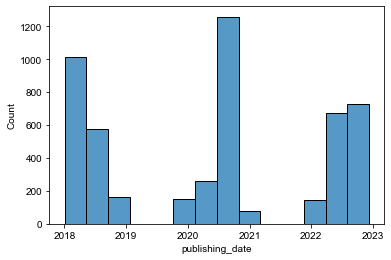

In [6]:
sns.histplot(df['publishing_date'])
sns.set(rc={'figure.figsize':(10,6)})

### Topic Modelling

In [7]:
import spacy

In [8]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim import models
from gensim.models import CoherenceModel
from gensim import corpora

from pymystem3 import Mystem

import pymorphy2

import pyLDAvis.gensim_models
from string import punctuation
from autocorrect import Speller
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\miste\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\miste\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\miste\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\miste\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [9]:
#r, n, t, \, цифры, пунктуация 
punctuation = punctuation + '0123456789rnt№«»'

In [10]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~0123456789rnt№«»'

In [11]:
import warnings
warnings.simplefilter('ignore')

def custom_tokenizer(t):
    word_tokens = nltk.word_tokenize(t.lower(), language="russian")
    word_tokens = [token.strip() for token in word_tokens]
    
    morph = pymorphy2.MorphAnalyzer(lang='ru')
    lemmatize_text = [morph.parse(w)[0].normal_form for w in word_tokens]
    
    # когда смотрел результаты модели, периодически изменял данный список
    bad_words = ["прошу", "р-он", "...", "здравствуйте", \
                 "мешаеткомфортно", "спасибо", \
                 "``", "''", "т.к.", "пожалуйста", "пожалуйста", "из-за", "нечипас", "анна", "товар", "адрес", "квартира", \
                 "дом", "подъезд", "href=http", "href=", "граффити", "санитарный", "детский", "который", "деньга", "день", \
                 "добрый", "просить", "ребёнок", "подсказать"]
    russian_stopwords = stopwords.words("russian")

    
    word_tokens = [token for token in lemmatize_text if token not in punctuation \
                   and token not in bad_words \
                   and token not in russian_stopwords \
                   and token not in 
                           re.findall(r"[\d]{1,4}.[\d]{1,4}.[\d]{1,4}", token) + 
                           re.findall(r"[\d]{1,4}-[\d]{1,4}-[\d]{1,4}", token) + 
                           re.findall(r"[\d]{1,4}.[\d]{1,4}.", token) \
                   and token not in 
                           re.findall('^[a-zA-Z0-9]*$', token)  # не анагл / англ + num
                  ]
    
    #mystem = Mystem()
    #lemmatize_text = [mystem.lemmatize(word)[0] for word in word_tokens] 
    
    #lemmatizer = WordNetLemmatizer()
    #lemmatize_text = [lemmatizer.lemmatize(w) for w in word_tokens]
    
    return word_tokens

In [ ]:
import warnings
warnings.simplefilter('ignore')

clean_text = [custom_tokenizer(df.corpus_name[i]) for i in range(len(df))]
clean_text = [
     [word for word in document if '.' not in word \
                                and '-' not in word \
                                and '№' not in word \
                                and '+' not in word \
                                and '/' not in word \
                                and ',' not in word \
                                and len(word) > 3
                                and word.isdigit()==False]
     for document in clean_text
 ]

Векторизация TF-IDF (не стал использовать что-то более сложное по типу Word2Vec и т.д. Пока ограничился tfidf как baseline решением)

In [14]:
dictionary = corpora.Dictionary(clean_text)
corpus = [dictionary.doc2bow(text) for text in clean_text]

tfidf_model = models.TfidfModel(corpus) 
tfidf = tfidf_model[corpus]

##### LDA & LSI

In [16]:
import numpy as np
lda_res = []
lsi_res = []
for i in range(2, 21):
    lda_model = models.LdaModel(tfidf, id2word=dictionary, num_topics=i, random_state=100)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=clean_text, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    lda_res.append(coherence_lda)
    
    lsi_model = models.LsiModel(tfidf, id2word=dictionary, num_topics=i, random_seed=98)
    coherence_model_lsi = CoherenceModel(model=lsi_model, texts=clean_text, dictionary=dictionary, coherence='c_v')
    coherence_lsi = coherence_model_lsi.get_coherence()
    lsi_res.append(coherence_lsi)

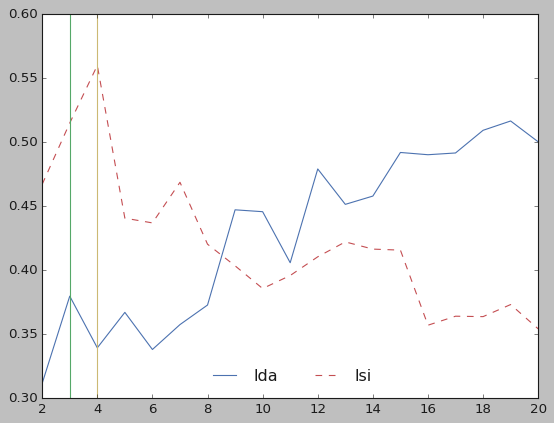

In [24]:
plt.style.use('classic')
x = [i for i in range(2,21)]
fig, ax = plt.subplots()
ax.plot(np.array(x), np.array(lda_res), '-b', label='lda')
ax.plot(np.array(x), np.array(lsi_res), '--r', label='lsi')
leg = ax.legend(frameon=False, loc='lower center', ncol=2)
plt.axvline(x=3, color='g')
plt.axvline(x=4, color='y')

In [25]:
print(f'max_LDA_score: {max(lda_res)};\nmax_LSI_score: {max(lsi_res)}')

max_LDA_score: 0.5160685237792819;
max_LSI_score: 0.5594747400053826


Как видно, наилучший score получился у модели lsi при выделении 4 топиков. Также при выделении 3 топиков, score lsi модели будет всеравно лучше чем у lda и не намного меньше чем при выделении 4 топиков в lsi. Данные на сайте Роспотребнадзора примерно об одном и том же, и чтобы не плодить много топиков, которые по входимым в них словам могут пересекаться между собой, я остановлюсь на выборе 3 топиков, немного жертвуя качеством.

In [27]:
lsi = models.LsiModel(tfidf, id2word=dictionary, num_topics=3, power_iters = 100, random_seed=98)
corpus_lsi = lsi[tfidf]

In [28]:
lsi.print_topics()

[(0,
  '0.193*"магазин" + 0.176*"возврат" + 0.141*"заказ" + 0.137*"средство" + 0.127*"вернуть" + 0.126*"телефон" + 0.120*"продавец" + 0.114*"денежный" + 0.111*"договор" + 0.104*"срок"'),
 (1,
  '0.266*"заказ" + -0.245*"маска" + 0.193*"возврат" + -0.187*"тест" + -0.151*"потребитель" + -0.139*"статья" + -0.137*"закон" + 0.126*"вернуть" + 0.126*"денежный" + 0.125*"доставка"'),
 (2,
  '-0.464*"тест" + 0.204*"магазин" + -0.184*"результат" + 0.179*"маска" + -0.151*"сдавать" + -0.149*"сдать" + 0.148*"потребитель" + -0.146*"анализ" + -0.145*"граница" + -0.134*"госуслуга"')]

In [30]:
# Compute Coherence Score for lsi model
# При добавлении параметра power_iters = 100 на 3 топиках score пооучился выше чем при изначальном определении лучшей модели
coherence_model_lda = CoherenceModel(model=lsi, texts=clean_text, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5675758619131944


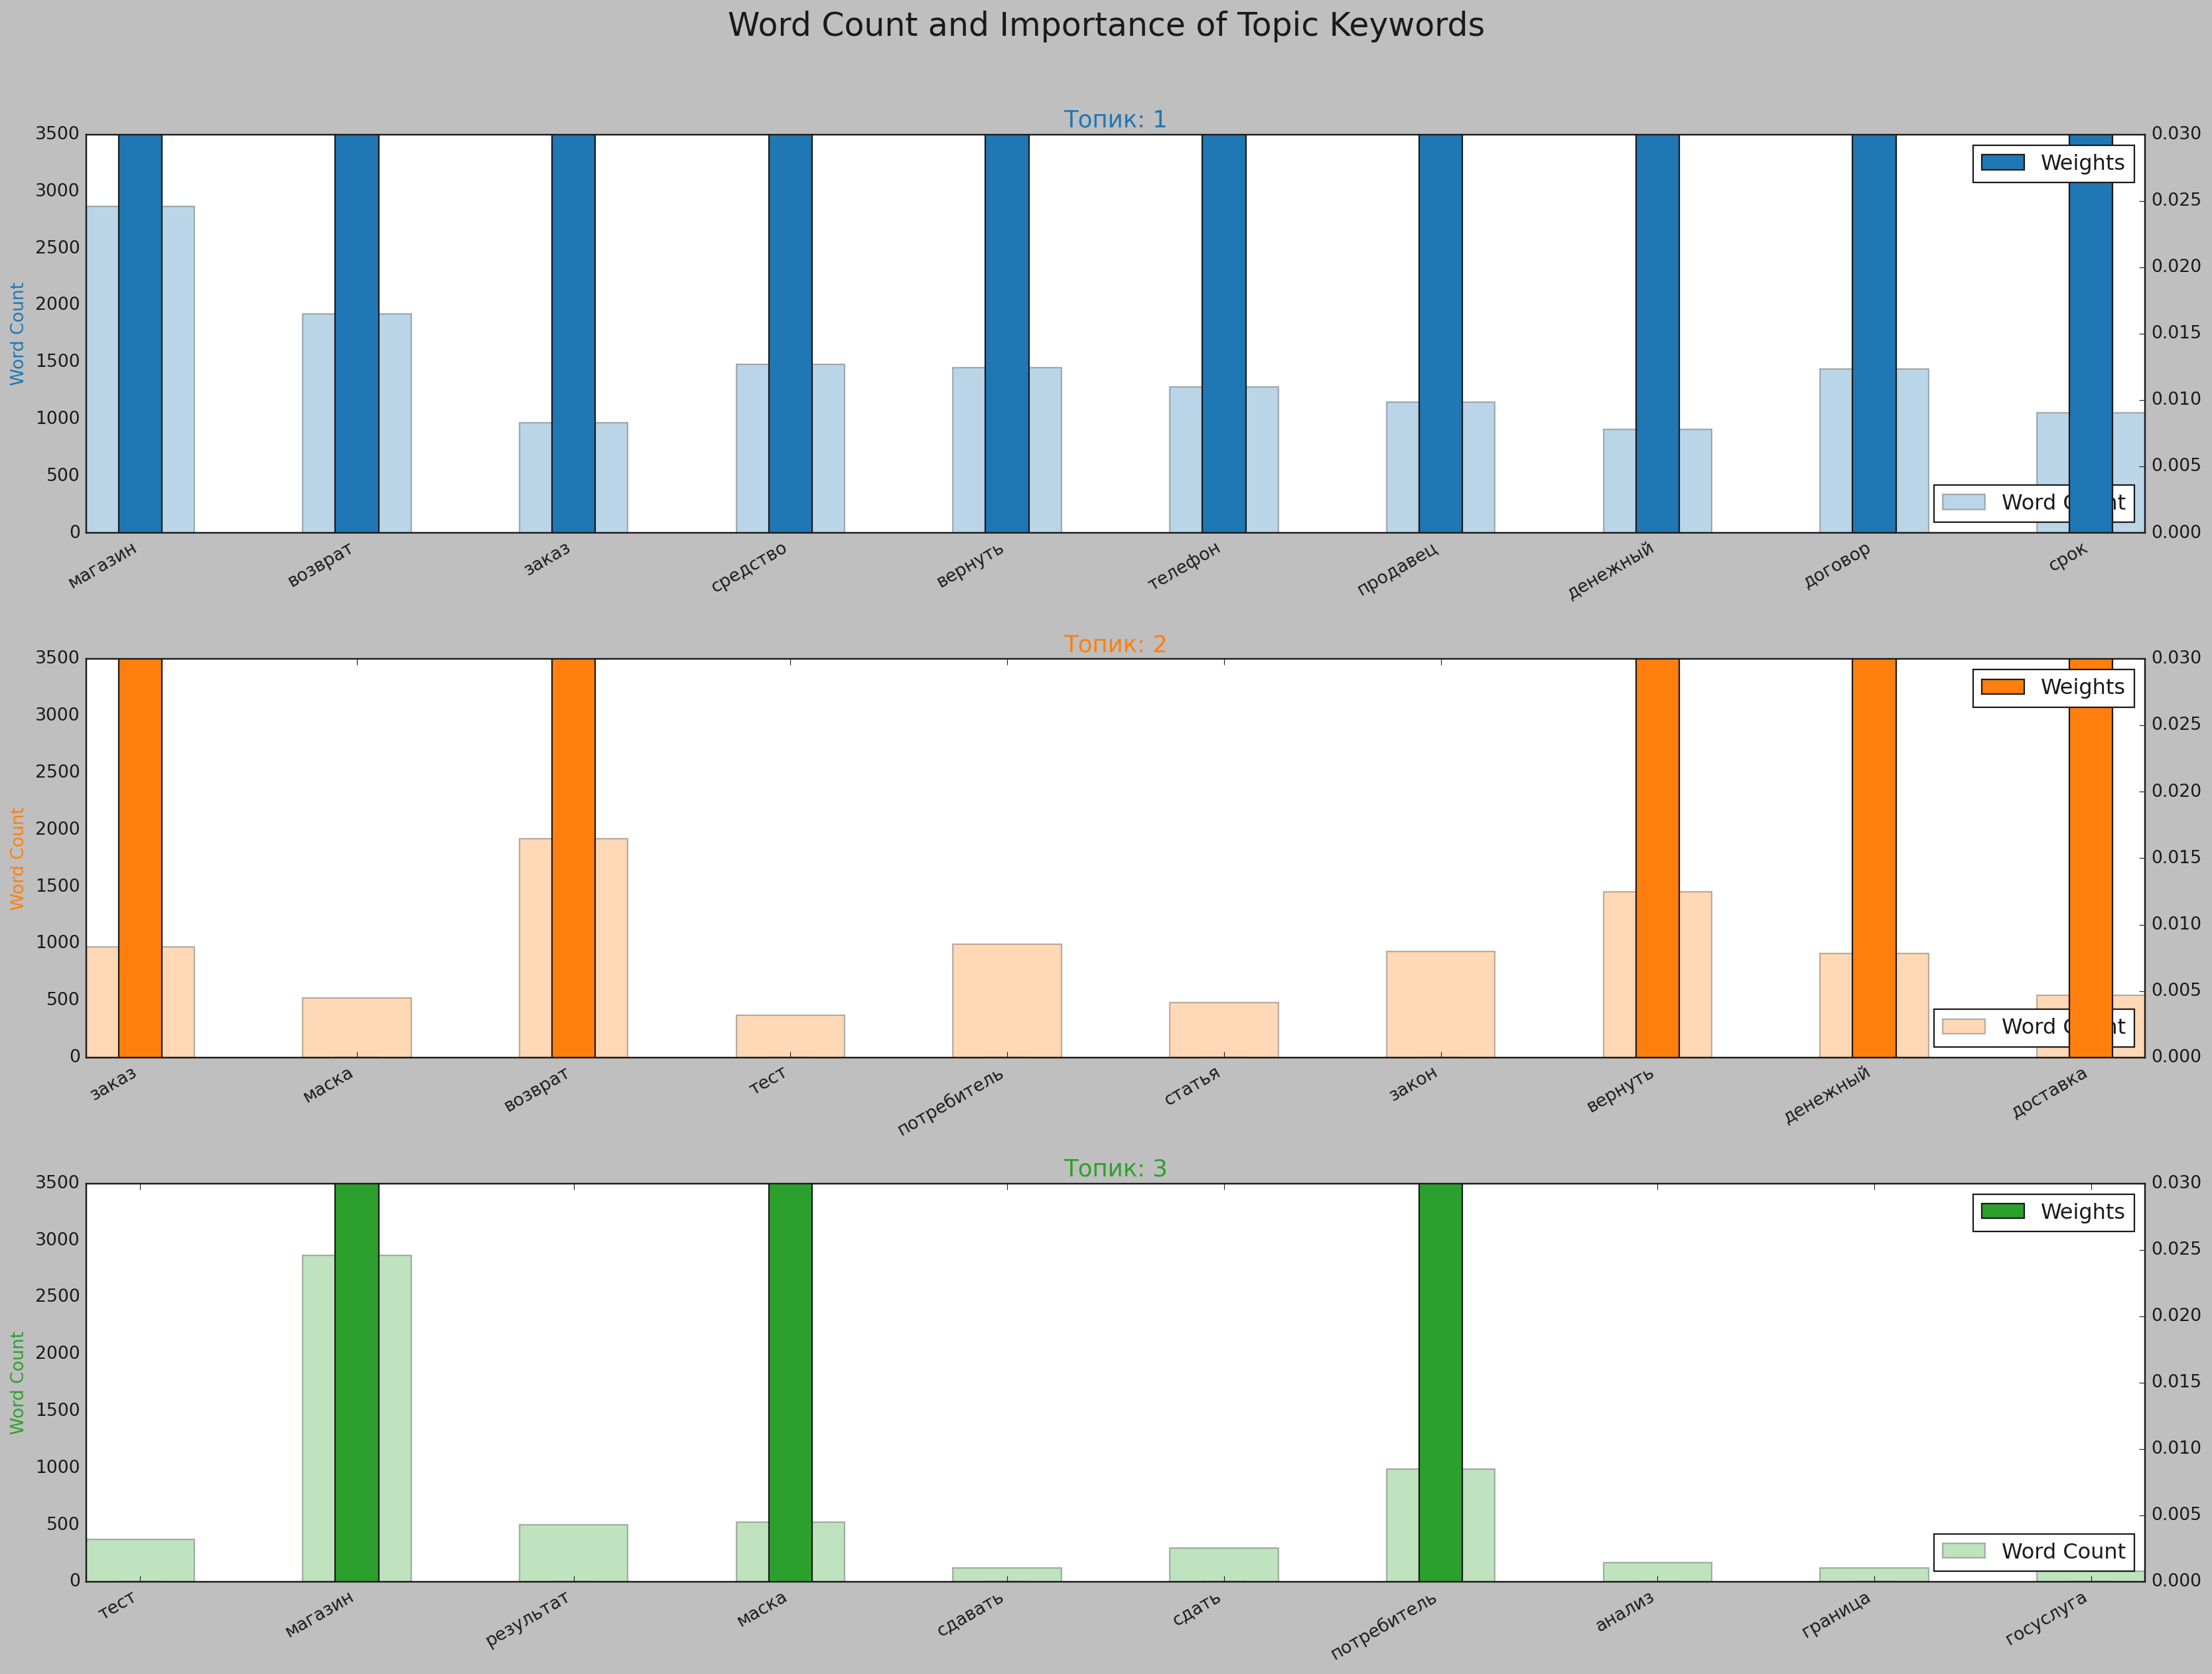

In [31]:
from matplotlib import colors as mcolors
from collections import Counter
topics = lsi.show_topics(formatted=False)
data_flat = [w for w_list in clean_text for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 1, figsize=(21,15), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], \
           color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Топик: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='lower right'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

Выделенные топики могут говорить о разном периоде времени. Так как я загружал страницы с начала, середины и конца списка, то в базу попали данные за разный период времени. Например, к **третьему** топику скорее всего относятся документы взятые из середины списка страниц (как раз, когда были ковидные времена), так как фигурируют слова: маска, тест. **Третий** топик, скорее всего, может говорить о нарушении прав потребителей в связи с требованием о ношении масок в ковидные времена. **Первый** топик также говорит о нарушении прав пользователей (что впринципе и должно находится в обращениях на сайте роспотребнадзора), но отсылки к covid уже нет. **Второй** топик, на мой взгляд, описывает документы, в которых указана конкретная претензия к заказанному товару.

Полученными топиками можно промаркировать наблюдения в датасете и построить модель классификатор.

In [65]:
# Функция создает DF, в котором для каждого документа будет проставлен доминирующий топик
def format_topics_sentences(ldamodel, corpus, texts):
   
    sent_topics_df = pd.DataFrame()

   
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # -- dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = \
                sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
    

df_topic_sents_keywords = format_topics_sentences(ldamodel=lsi, corpus=corpus, texts=clean_text)


df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [66]:
(len(df_dominant_topic[df_dominant_topic.Dominant_Topic == 0]),
len(df_dominant_topic[df_dominant_topic.Dominant_Topic == 1]),
len(df_dominant_topic[df_dominant_topic.Dominant_Topic == 2]))

(4976, 12, 50)

Наша выборка получилась очень несбалансированной. У первого класса гораздо больше элементов чем у второго и третьего. Чтобы не работать с несбалансированными данными и избавиться от возможной ошибки (когда предпочтения будут отдаваться одному из классов), можно использовать метод **Upsampling**, для того чтобы избавиться от дисбаланса. Второй и третий топики (так как они довольно близки по смыслу) можно объединить в одну группу и решать уже задачу бинарной классификации. Но все же, более разумным решением будет запарсить еще данных с сайта Роспотребнадзора. Посмотреть в какой период времени наименее встречающиеся топики чаще всего фигурируют, и в этом временном промежутке взять еще набор текстов.